# Neural Bandit

Implementing neural bandit using scikit-learn's multilayer perceptron.

In this example, we use a simple neural network to predict the action's value. This has the advantage of being able to just use the neural network to map all the possible states (context).

We can pick the action with the highest predicted reward, or apply other policies such as e-greedy or softmax.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np

In [2]:
USER_LIKED_ARTICLE = 1.0
USER_DISLIKED_ARTICLE = -1.0

## Initial Cost Function

In [3]:
def get_cost(context, action):
    match (context["user"], context["time_of_day"], action):
        case ("Tom", "morning", "politics"):
            return USER_LIKED_ARTICLE
        case ("Tom", "afternoon", "music"):
            return USER_LIKED_ARTICLE
        case ("Anna", "morning", "sports"):
            return USER_LIKED_ARTICLE
        case ("Anna", "afternoon", "politics"):
            return USER_LIKED_ARTICLE
        case _:
            return USER_DISLIKED_ARTICLE

## Preprocessing

### One Hot Encoding

One hot encoding can be used to convert the categorical features to numbers. However, there is a limitation where the input has to be of fixed size. So if there are new features introduced, we may not be able to fit the neural network. An alternative approach is to use **feature hashing**, which we will explore later.

We still demonstrate the usage of one hot encoding as a comparison.

In [4]:
users = ["Tom", "Anna"]
times_of_day = ["morning", "afternoon"]
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]


def one_hot_encode(user, time_of_day, action):
    return [users.index(user) + 1, times_of_day.index(time_of_day) + 1] + [
        1 if a == action else 0 for a in actions
    ]


one_hot_encode("Tom", "morning", "politics")

[1, 1, 1, 0, 0, 0, 0, 0, 0]

### Feature Hashing

Feature hashing allows us to work with a larger set of dynamic features. The disadvantage is that as the feature size grow, it is prone to collision which might lead to the neural network learning the wrong thing.

In [5]:
from sklearn.feature_extraction import FeatureHasher

hasher = FeatureHasher(n_features=10, input_type="string")

# The order does not matter.
print(hasher.transform([["a", "b", "c"]]).toarray())
print(hasher.transform([["c", "a", "b"]]).toarray())

[[ 1. -1.  0.  0.  0.  0.  0. -1.  0.  0.]]
[[ 1. -1.  0.  0.  0.  0.  0. -1.  0.  0.]]


In [6]:
# The input size does not matter.
print(hasher.transform([["a", "b"]]).toarray())
print(hasher.transform([["a", "b", "c"]]).toarray())

# The input numbers matter.
print(hasher.transform([["a", "b", "b"]]).toarray())

[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 1. -1.  0.  0.  0.  0.  0. -1.  0.  0.]]
[[ 1. -2.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [7]:
from itertools import combinations_with_replacement

# This is similar to how vowpal wabbit does the feature interaction.
print(list(combinations_with_replacement("abc", 2)))
print(list(combinations_with_replacement(["Tom", "politics"], 2)))

[('a', 'a'), ('a', 'b'), ('a', 'c'), ('b', 'b'), ('b', 'c'), ('c', 'c')]
[('Tom', 'Tom'), ('Tom', 'politics'), ('politics', 'politics')]


In [34]:
hasher = FeatureHasher(n_features=100, input_type="string")


# https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Feature-interactions
# https://vowpalwabbit.org/docs/vowpal_wabbit/python/latest/tutorials/python_Simulating_a_news_personalization_scenario_using_Contextual_Bandits.html#:~:text=supply%20to%20VW-,%2C%20we%20include%20%2Dq%20UA,-.%20This%20is%20telling
def feature_interaction(user, time_of_day, action, debug=False):
    """perform feature interactions, similar to how vowpal wabbit does it.
    We create additional features which are the features in the (U)ser namespace and (A)ction
    namespaces multiplied together.
    This allows us to learn the interaction between when certain actions are good in certain times of days and for particular users.
    If we didn’t do that, the learning wouldn’t really work.
    We can see that in action below.
    """
    features = [
        f"user:{user}",
        f"action:{action}^user:{user}",
        f"time_of_day:{time_of_day}^user:{user}",
    ]

    # X_times_of_day = [f"time_of_day:{tod}:{tod==time_of_day}" for tod in times_of_day]
    # features += X_times_of_day
    # features += [f"{f}^user:{user}" for f in X_times_of_day]

    # X_actions = [f"action:{a}:{a==action}" for a in actions]
    # features += X_actions
    # features += [f"{f}^user:{user}" for f in X_actions]
    if debug:
        print(features)
    return hasher.transform([features]).toarray()[0]

Here we can see that the encoded output will be different for different input.

In [35]:
feature_interaction("Tom", "morning", "politics", debug=True)

['user:Tom', 'action:politics^user:Tom', 'time_of_day:morning^user:Tom']


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
feature_interaction("Tom", "afternoon", "politics")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Policy

### Softmax

In [37]:
import numpy as np


def softmax(lst, tau=1.0):
    lst = np.array(lst) / tau
    exps = np.exp(lst)
    return exps / np.sum(exps)

<Axes: title={'center': 'Probabilities against temperature'}, xlabel='Probabilities', ylabel='Temperature'>

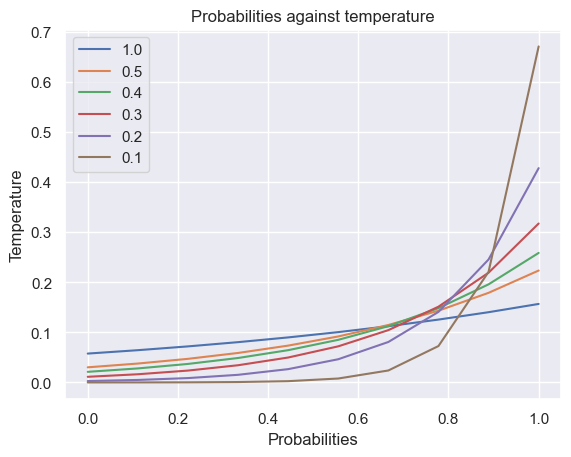

In [38]:
import pandas as pd
import seaborn as sns

# Apply the default theme
sns.set_theme()

taus = [1.0, 0.5, 0.4, 0.3, 0.2, 0.1]
probs = np.linspace(0, 1, 10)
pd.DataFrame({tau: softmax(probs, tau) for tau in taus}, index=probs).plot(
    xlabel="Probabilities",
    ylabel="Temperature",
    title="Probabilities against temperature",
)

In [39]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(random_state=42)
model.partial_fit([one_hot_encode("Tom", "morning", "politics")], [1])
model.predict([one_hot_encode("Tom", "morning", "politics")])

array([0.20727216])

In [40]:
# Sampling best reward for the action taken.
rewards = model.predict(
    [one_hot_encode("Tom", "morning", action) for action in actions]
)
p = softmax(rewards)
action = np.random.choice(actions, p=p)
rewards, p, action

(array([ 0.20727216,  0.11697445,  0.33291172,  0.24473987,  0.35555384,
         0.13795523, -0.00638099]),
 array([0.14313913, 0.13078037, 0.16230165, 0.14860396, 0.16601842,
        0.13355323, 0.11560323]),
 'food')

In [41]:
model = MLPRegressor(activation="relu", random_state=42)
model.partial_fit([feature_interaction("Tom", "morning", "politics")], [1])
model.predict([feature_interaction("Tom", "morning", "politics")])

array([-0.13757706])

In [42]:
# Sampling best reward for the action taken.
rewards = model.predict(
    [feature_interaction("Tom", "morning", action) for action in actions]
)
p = softmax(rewards)
action = np.random.choice(actions, p=p)
rewards, p, action

(array([-0.13757706, -0.23955037, -0.16971928, -0.25616586, -0.22696235,
        -0.20543623, -0.22881596]),
 array([0.15334412, 0.13847797, 0.14849367, 0.1361961 , 0.14023215,
        0.14328353, 0.13997246]),
 'politics')

In [43]:
p = softmax(rewards, tau=0.2)
action = np.random.choice(actions, p=p)
rewards, p, softmax(rewards), action

(array([-0.13757706, -0.23955037, -0.16971928, -0.25616586, -0.22696235,
        -0.20543623, -0.22881596]),
 array([0.20038616, 0.12034706, 0.17063644, 0.11075298, 0.12816517,
        0.14272938, 0.12698281]),
 array([0.15334412, 0.13847797, 0.14849367, 0.1361961 , 0.14023215,
        0.14328353, 0.13997246]),
 'politics')

In [44]:
def choose_user(users):
    return random.choice(users)


def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)


def get_action(model, context, actions, preprocess, /, policy="greedy"):
    rewards = model.predict(
        [
            preprocess(context["user"], context["time_of_day"], action)
            for action in actions
        ]
    )
    action = None
    match policy:
        case "greedy":
            action = actions[np.argmax(rewards)]
        case "softmax":
            action = np.random.choice(actions, p=softmax(rewards, tau=0.2))
        case _:
            raise ValueError(f'unknown policy "{policy}"')

    return action

In [45]:
get_action(
    model,
    {"user": "Tom", "time_of_day": "morning"},
    ["politics", "sports"],
    feature_interaction,
)

'politics'

In [46]:
from tqdm import tqdm


def run_simulation(
    model,
    num_iterations,
    users,
    times_of_day,
    actions,
    cost_function,
    do_learn=True,
    preprocess=one_hot_encode,
    policy="greedy",
):
    cost_sum = 0.0
    ctr = []

    for i in tqdm(range(1, num_iterations + 1)):
        # 1. In each simulation choose a user
        user = choose_user(users)

        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action
        context = {"user": user, "time_of_day": time_of_day}

        action = None
        if i == 1:
            action = np.random.choice(actions)
        else:
            action = get_action(
                model,
                context,
                actions,
                preprocess,
                policy=policy,
            )

        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        # We use negative scores for training the neural network, but only add up positive scores for rewards.
        cost_sum += max(cost, 0)

        if do_learn:
            # 5. Learn
            model.partial_fit([preprocess(user, time_of_day, action)], [cost])

        ctr.append(cost_sum / i)

    return ctr

In [47]:
import pandas as pd

preprocessors = [
    one_hot_encode,
    one_hot_encode,
    feature_interaction,
    feature_interaction,
]
policies = ["greedy", "softmax", "greedy", "softmax"]

num_iterations = 5000

df = pd.DataFrame(index=range(num_iterations))

for preprocess, policy in zip(preprocessors, policies):
    name = f"{preprocess.__name__}_{policy}"

    # Create a new model for each tests.
    model = MLPRegressor(random_state=42)
    df[name] = run_simulation(
        model,
        num_iterations,
        users,
        times_of_day,
        actions,
        get_cost,
        preprocess=preprocess,
        policy=policy,
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 353.77it/s]


<Axes: >

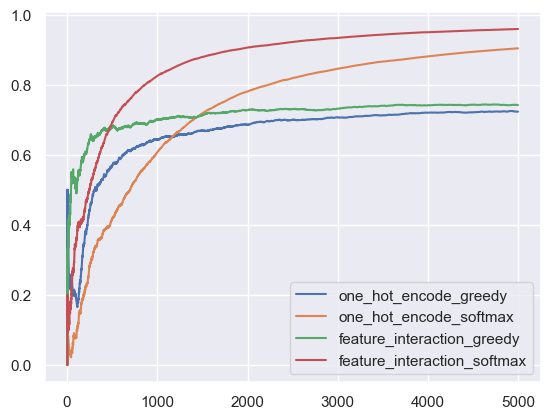

In [48]:
df.plot()

In [49]:
context = {"user": "Anna", "time_of_day": "morning"}
get_action(model, context, actions, feature_interaction)

'sports'

In [50]:
context = {"user": "Anna", "time_of_day": "afternoon"}
get_action(model, context, actions, feature_interaction)

'politics'

## Updated Cost Function

In [51]:
def get_cost_new1(context, action):
    match (context["user"], context["time_of_day"], action):
        case ("Tom", "morning", "politics"):
            return USER_LIKED_ARTICLE
        case ("Tom", "afternoon", "sports"):
            return USER_LIKED_ARTICLE
        case ("Anna", "morning", "sports"):
            return USER_LIKED_ARTICLE
        case ("Anna", "afternoon", "sports"):
            return USER_LIKED_ARTICLE
        case _:
            return USER_DISLIKED_ARTICLE

In [52]:
def run_simulation_multiple_cost_functions(
    model,
    num_iterations,
    users,
    times_of_day,
    actions,
    cost_functions,
    do_learn=True,
    preprocess=feature_interaction,
    policy="greedy",
):
    cost_sum = 0.0
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in tqdm(range(start_counter, end_counter)):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {"user": user, "time_of_day": time_of_day}

            # 3. Use the get_action function we defined earlier
            if i == 1:
                action = np.random.choice(actions)
            else:
                action = get_action(model, context, actions, preprocess, policy=policy)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += max(cost, 0)

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                model.partial_fit([preprocess(user, time_of_day, action)], [cost])

            ctr.append(cost_sum / i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

In [53]:
import pandas as pd

preprocessors = [
    one_hot_encode,
    one_hot_encode,
    feature_interaction,
    feature_interaction,
]
policies = ["greedy", "softmax", "greedy", "softmax"]
cost_functions = [get_cost, get_cost_new1, get_cost_new1]
num_iterations_per_cost_func = 5000
total_iterations = num_iterations_per_cost_func * len(cost_functions)

df = pd.DataFrame(index=range(total_iterations))

for preprocess, policy in zip(preprocessors, policies):
    name = f"{preprocess.__name__}_{policy}"

    # Create a new model for each tests.
    model = MLPRegressor(random_state=42)
    df[name] = run_simulation_multiple_cost_functions(
        model,
        num_iterations,
        users,
        times_of_day,
        actions,
        cost_functions,
        preprocess=preprocess,
        policy=policy,
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 293.74it/s]


<Axes: >

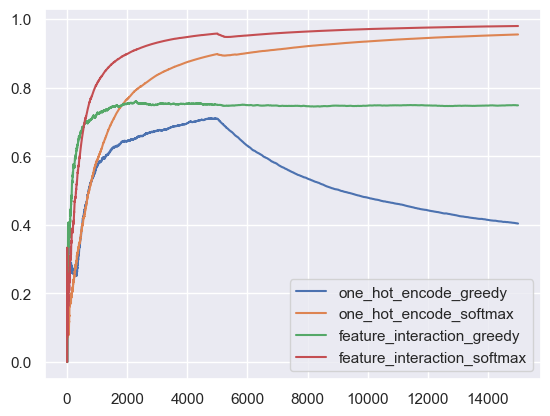

In [54]:
df.plot()